In [47]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [48]:

root_path = "/major project/btc_23_feb.csv"
btc_input_df = pd.read_csv(root_path)
btc_input_df.tail()

,time,low,high,open,close,volume
603650,2023-02-24 05:42:00,23902.35,23909.49,23902.35,23909.47,0.861892
603651,2023-02-24 05:43:00,23901.26,23909.47,23909.47,23905.26,0.796059
603652,2023-02-24 05:44:00,23901.01,23905.30,23905.26,23903.20,0.451450
603653,2023-02-24 05:45:00,23893.85,23905.06,23903.19,23897.22,1.657772
603654,2023-02-24 05:46:00,23895.14,23901.40,23897.20,23897.88,0.793310


In [49]:
btc_input_df.shape

(603655, 6)

In [50]:
btc_input_df.describe()

,low,high,open,close,volume
count,603655.000000,603655.000000,603655.000000,603655.000000,603655.000000
mean,27338.269401,27367.217001,27352.857297,27352.895648,15.531793
std,9822.911043,9834.358245,9828.697523,9828.665417,22.695514
min,15460.000000,15529.530000,15497.220000,15497.240000,0.046753
25%,19527.790000,19547.000000,19537.465000,19537.445000,4.292517
50%,22888.080000,22908.380000,22898.640000,22898.610000,8.983928
75%,38338.980000,38384.335000,38361.730000,38361.855000,18.256608
max,48152.410000,48240.000000,48203.470000,48203.430000,1177.512807


In [51]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603655 entries, 0 to 603654
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    603655 non-null  object 
 1   low     603655 non-null  float64
 2   high    603655 non-null  float64
 3   open    603655 non-null  float64
 4   close   603655 non-null  float64
 5   volume  603655 non-null  float64
dtypes: float64(5), object(1)
memory usage: 27.6+ MB


In [52]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})

In [53]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603655 entries, 0 to 603654
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    603655 non-null  datetime64[ns]
 1   low     603655 non-null  float64       
 2   high    603655 non-null  float64       
 3   open    603655 non-null  float64       
 4   close   603655 non-null  float64       
 5   volume  603655 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 27.6 MB


In [54]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())

Null Values: 0
If any NA values: False


In [55]:
btc_input_df_datetype.tail()

,time,low,high,open,close,volume
603650,2023-02-24 05:42:00,23902.35,23909.49,23902.35,23909.47,0.861892
603651,2023-02-24 05:43:00,23901.26,23909.47,23909.47,23905.26,0.796059
603652,2023-02-24 05:44:00,23901.01,23905.30,23905.26,23903.20,0.451450
603653,2023-02-24 05:45:00,23893.85,23905.06,23903.19,23897.22,1.657772
603654,2023-02-24 05:46:00,23895.14,23901.40,23897.20,23897.88,0.793310


In [56]:
btc_input_df_datetype.head()

,time,low,high,open,close,volume
0,2022-01-01 00:01:00,46228.00,46327.61,46244.63,46301.29,22.578581
1,2022-01-01 00:02:00,46284.81,46372.55,46305.44,46345.08,38.435608
2,2022-01-01 00:03:00,46299.97,46377.10,46345.08,46320.30,8.236354
3,2022-01-01 00:04:00,46285.70,46329.09,46316.24,46306.89,16.319029
4,2022-01-01 00:05:00,46268.25,46422.94,46315.10,46413.83,40.695435


<AxesSubplot: title={'center': 'Bitcoin Weighted Price'}, xlabel='time'>

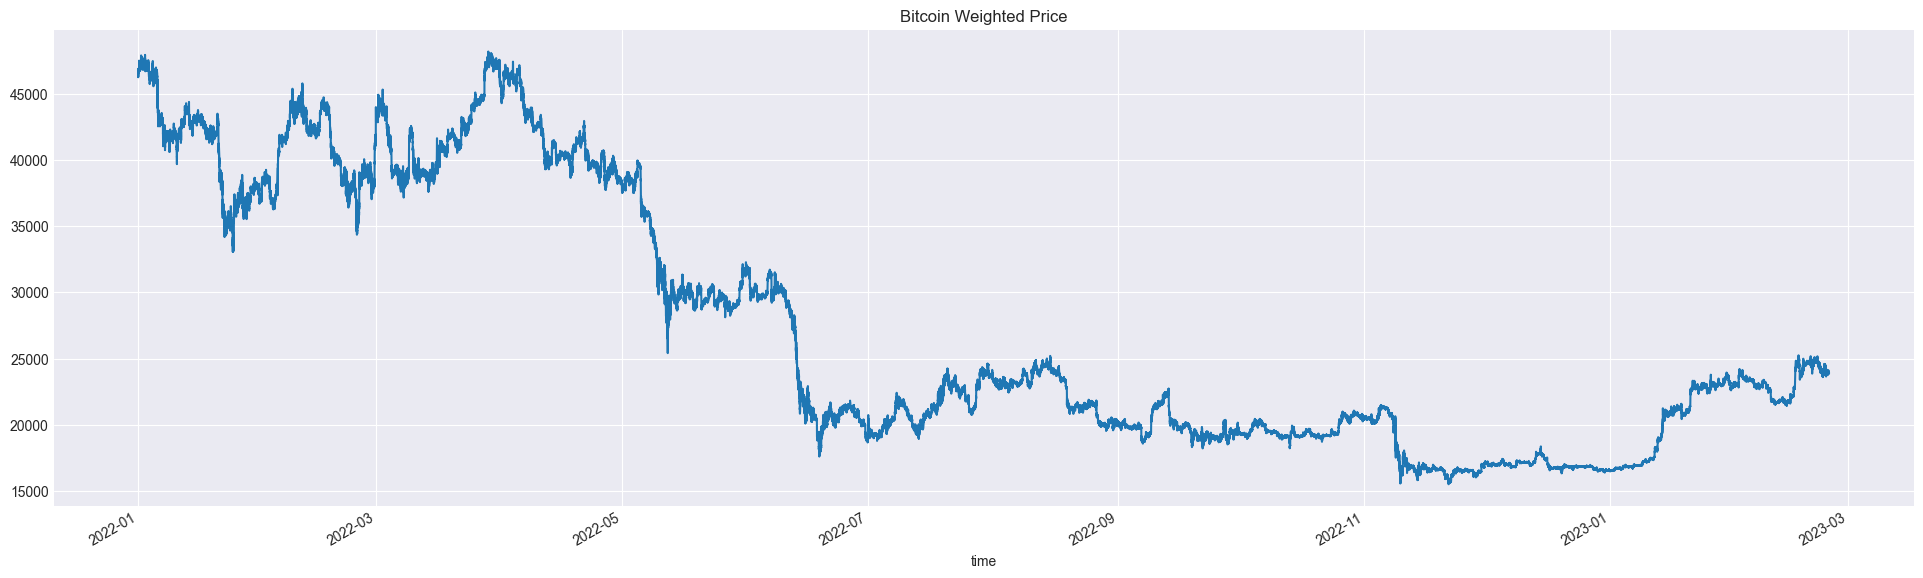

In [57]:
btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


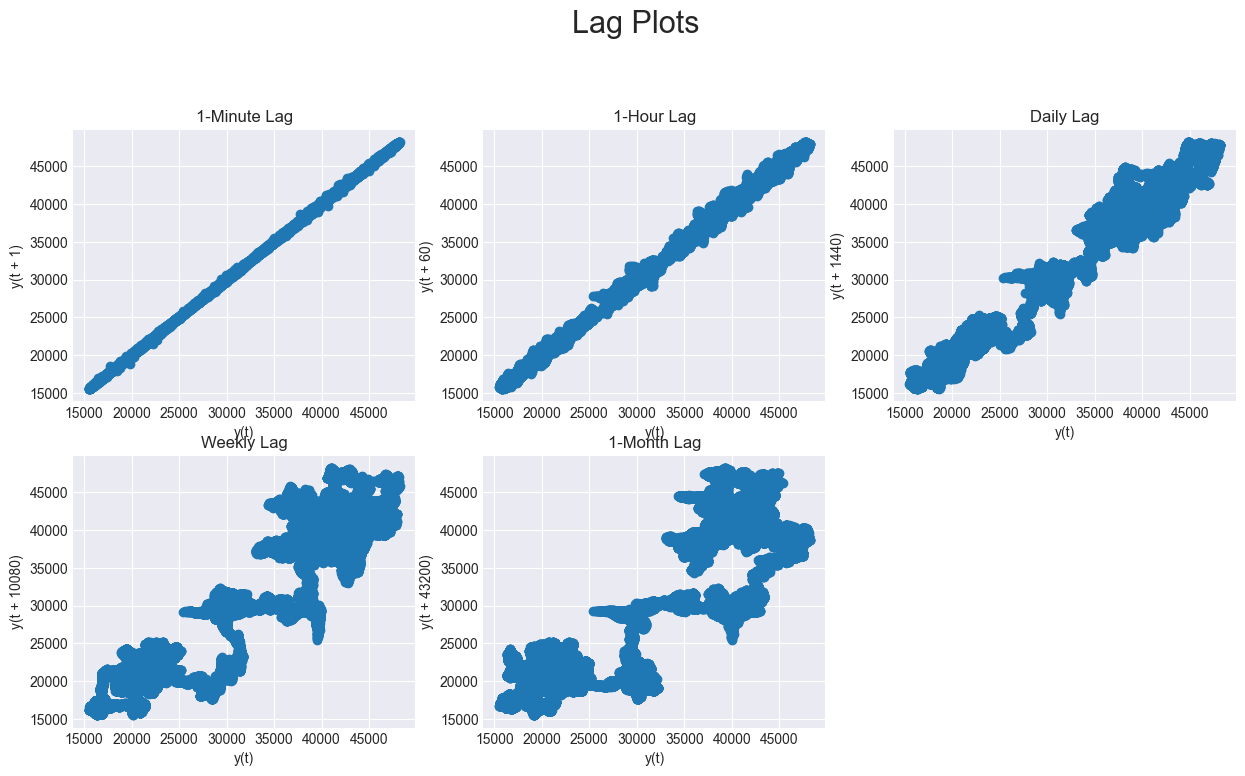

In [58]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [59]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2022-01-01 00:01:00,46228.00,46327.61,46244.63,46301.29,22.578581,2022-01-01
1,2022-01-01 00:02:00,46284.81,46372.55,46305.44,46345.08,38.435608,2022-01-01
2,2022-01-01 00:03:00,46299.97,46377.10,46345.08,46320.30,8.236354,2022-01-01
3,2022-01-01 00:04:00,46285.70,46329.09,46316.24,46306.89,16.319029,2022-01-01
4,2022-01-01 00:05:00,46268.25,46422.94,46315.10,46413.83,40.695435,2022-01-01


In [60]:
display(btc_closing_price_groupby_date.head(10))

print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

date
2022-01-01    47123.818131
2022-01-02    47247.516278
2022-01-03    46820.535917
2022-01-04    46428.382424
2022-01-05    45897.798590
2022-01-06    43091.874514
2022-01-07    41992.719007
2022-01-08    41709.443056
2022-01-09    41907.349264
2022-01-10    41615.205056
Name: close, dtype: float64

Length of btc_closing_price_groupby_date : 420


# Train Test Split

In [61]:
prediction_days = 60

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [62]:
df_test.shape


(60, 1)

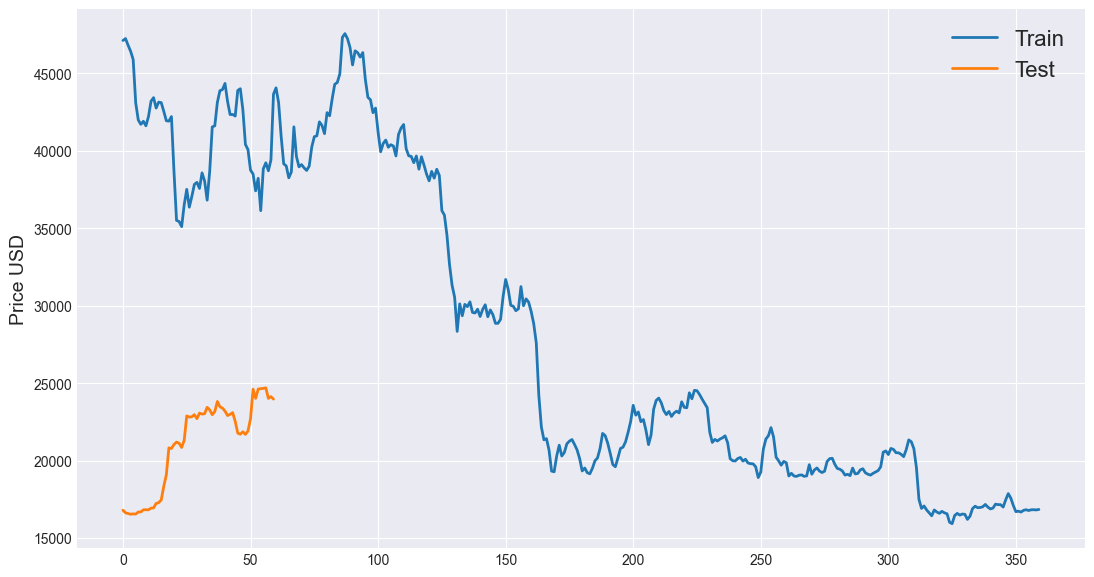

In [63]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [64]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [65]:
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY: ", testY.shape)

trainX:  (355, 5)
trainY:  (355,)
testX:  (55, 5)
testY:  (55,)


In [66]:
print("trainX: ", trainX)
# print("trainY: ", trainY)
# print("testY: ", testX)
# print("testY", testY)

trainX:  [[0.98601599 0.98992612 0.97642918 0.96403312 0.94726126]
 [0.98992612 0.97642918 0.96403312 0.94726126 0.85856541]
 [0.97642918 0.96403312 0.94726126 0.85856541 0.82382087]
 ...
 [0.023637   0.02715948 0.02837278 0.02674655 0.02830208]
 [0.02715948 0.02837278 0.02674655 0.02830208 0.02839532]
 [0.02837278 0.02674655 0.02830208 0.02839532 0.02796398]]


In [67]:
print(trainX.shape)
print(testX.shape)

(355, 5)
(55, 5)


### And now reshape trainX and testX 

In [68]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (355, 5, 1)
Shape of testX:  (55, 5, 1)


In [69]:
print("trainX: ", trainX)
print(" ********** ")
print("testX: ", testX)

trainX:  [[[0.98601599]
  [0.98992612]
  [0.97642918]
  [0.96403312]
  [0.94726126]]

 [[0.98992612]
  [0.97642918]
  [0.96403312]
  [0.94726126]
  [0.85856541]]

 [[0.97642918]
  [0.96403312]
  [0.94726126]
  [0.85856541]
  [0.82382087]]

 ...

 [[0.023637  ]
  [0.02715948]
  [0.02837278]
  [0.02674655]
  [0.02830208]]

 [[0.02715948]
  [0.02837278]
  [0.02674655]
  [0.02830208]
  [0.02839532]]

 [[0.02837278]
  [0.02674655]
  [0.02830208]
  [0.02839532]
  [0.02796398]]]
 ********** 
testX:  [[[0.03159908]
  [0.01096924]
  [0.00537844]
  [0.        ]
  [0.00232078]]

 [[0.01096924]
  [0.00537844]
  [0.        ]
  [0.00232078]
  [0.00104055]]

 [[0.00537844]
  [0.        ]
  [0.00232078]
  [0.00104055]
  [0.01748954]]

 [[0.        ]
  [0.00232078]
  [0.00104055]
  [0.01748954]
  [0.01763282]]

 [[0.00232078]
  [0.00104055]
  [0.01748954]
  [0.01763282]
  [0.03477404]]

 [[0.00104055]
  [0.01748954]
  [0.01763282]
  [0.03477404]
  [0.03514825]]

 [[0.01748954]
  [0.01763282]
  [0.03477

In [70]:
# checking the values for input_shape = (trainX.shape[1], trainX.shape[2])
# Note - `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [71]:
regressor = Sequential()

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
# callbacks = [checkpoint]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
10/12 [========================>.....] - ETA: 0s - loss: 0.2378
Epoch 1: val_loss improved from inf to 0.18759, saving model to my_best_model.hdf5
12/12 [==============================] - 5s 99ms/step - loss: 0.2150 - val_loss: 0.1876
Epoch 2/600
11/12 [==========================>...] - ETA: 0s - loss: 0.0820
Epoch 2: val_loss improved from 0.18759 to 0.02460, saving model to my_best_model.hdf5
12/12 [==============================] - 0s 21ms/step - loss: 0.0818 - val_loss: 0.0246
Epoch 3/600
10/12 [========================>.....] - ETA: 0s - loss: 0.0208
Epoch 3: val_loss did not improve from 0.02460
12/12 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0281
Epoch 4/600
11/12 [==========================>...] - ETA: 0s - loss: 0.0117
Epoch 4: val_loss improved from 0.02460 to 0.01879, saving model to my_best_model.hdf5
12/12 [==============================] - 0s 21ms/step - loss: 0.0117 - val_loss: 0.0188
Epoch 5/600
11/12 [=====================

In [73]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

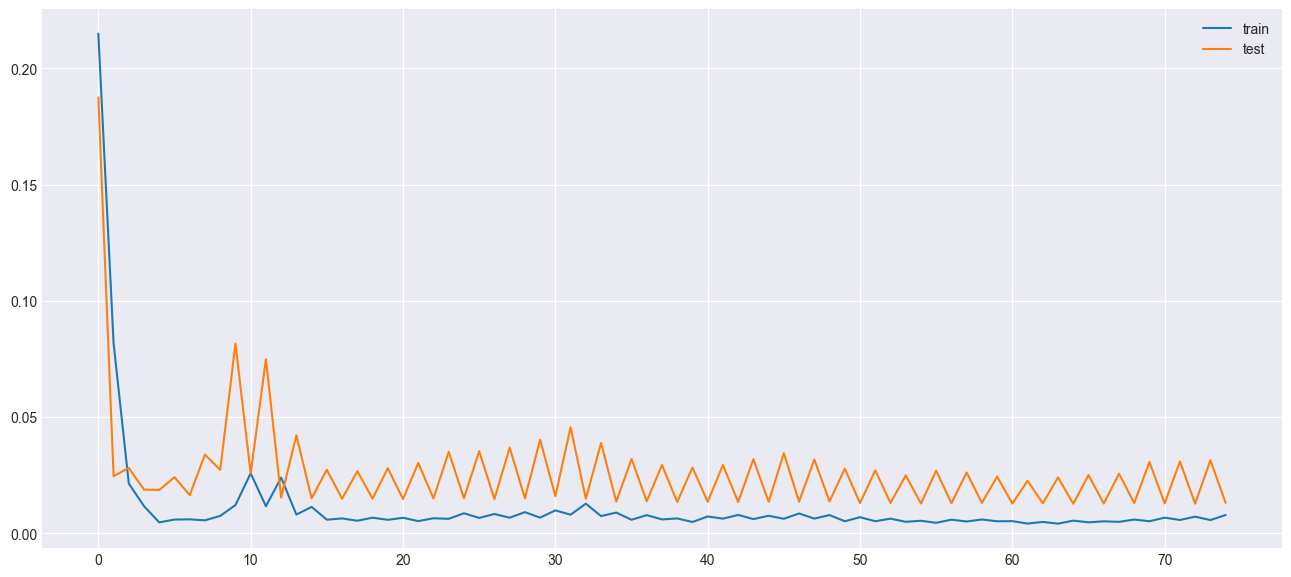

In [74]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [75]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

2/2 [==============================] - 1s 11ms/step


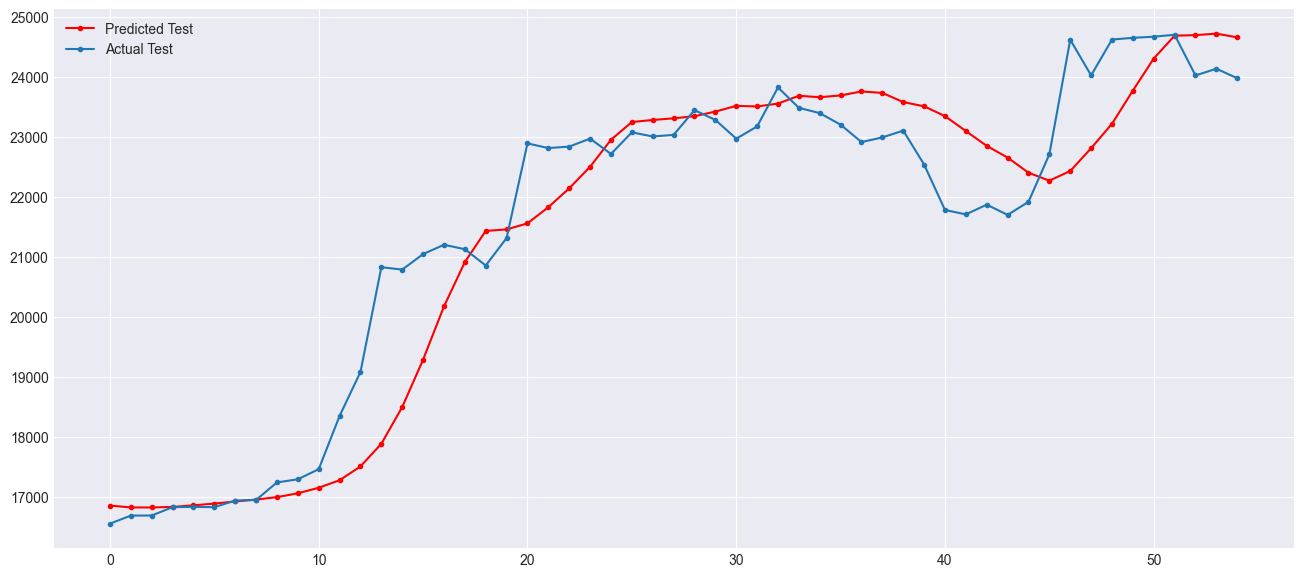

In [76]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [77]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

12/12 [==============================] - 0s 4ms/step


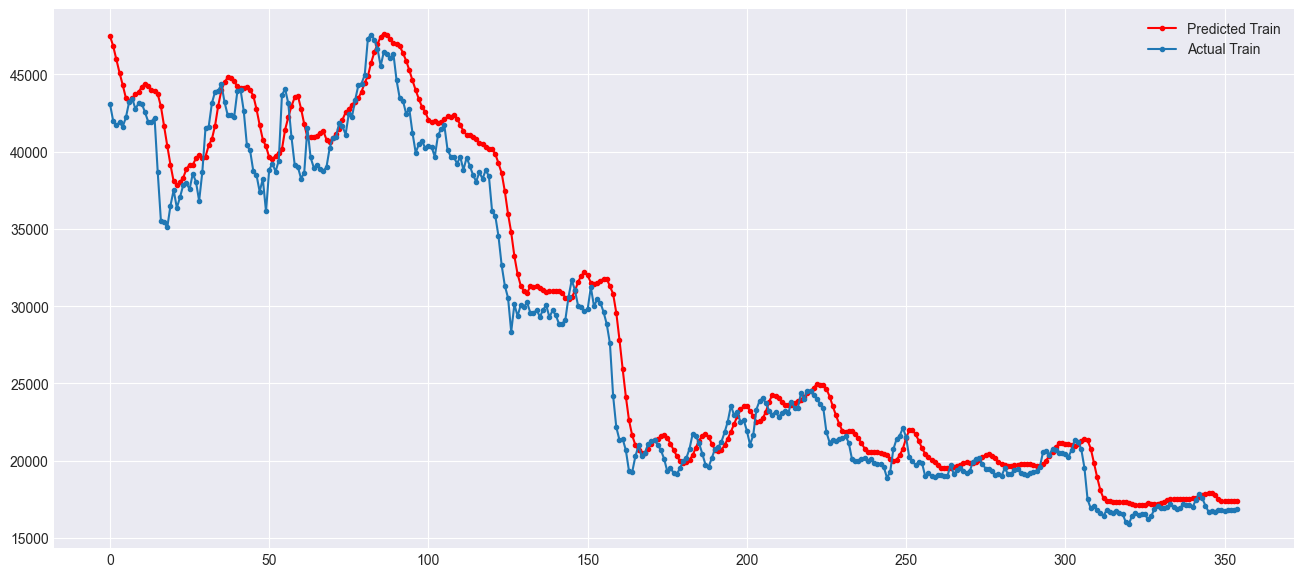

In [78]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [79]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best


Test RMSE: 919.176


In [80]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1047.916  => This seems best

Test RMSE: 2014.714


In [81]:
testX
testX.shape

(55, 5, 1)

In [82]:
lookback_period = 5

# That is the original Trading data ended on 30-Oct-2021, but going to forecast for Future 5 days beyond 30-Oct-2021

testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(5, 5, 1)

In [83]:
testX_last_5_days

array([[[0.75588631],
        [0.98993221],
        [0.91702008],
        [0.99033114],
        [0.99374746]],

       [[0.98993221],
        [0.91702008],
        [0.99033114],
        [0.99374746],
        [0.99608231]],

       [[0.91702008],
        [0.99033114],
        [0.99374746],
        [0.99608231],
        [1.        ]],

       [[0.99033114],
        [0.99374746],
        [0.99608231],
        [1.        ],
        [0.91686277]],

       [[0.99374746],
        [0.99608231],
        [1.        ],
        [0.91686277],
        [0.9306397 ]]])

In [84]:

predicted_5_days_forecast_price_test_x = []

for i in range(5):  
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])
  
  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
  
print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x)) 
# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast beyond 30-Oct-2021

1/1 [==============================] - 0s 40ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[24299.947]]

 [[24680.922]]

 [[24689.537]]

 [[24714.447]]

 [[24652.297]]]


In [85]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.shape

(5, 1, 1)

In [86]:
predicted_btc_price_test_data.shape

(55, 1)

In [87]:
predicted_btc_price_test_data

array([[16850.049],
       [16818.264],
       [16818.17 ],
       [16827.242],
       [16853.506],
       [16883.203],
       [16917.793],
       [16950.006],
       [16990.312],
       [17053.871],
       [17146.96 ],
       [17271.934],
       [17502.38 ],
       [17879.75 ],
       [18491.93 ],
       [19281.494],
       [20168.787],
       [20907.516],
       [21426.87 ],
       [21452.018],
       [21552.697],
       [21822.172],
       [22137.38 ],
       [22495.89 ],
       [22946.322],
       [23241.441],
       [23275.748],
       [23303.059],
       [23338.436],
       [23415.441],
       [23511.023],
       [23500.688],
       [23548.732],
       [23678.719],
       [23655.016],
       [23684.85 ],
       [23751.088],
       [23726.04 ],
       [23574.322],
       [23503.287],
       [23340.271],
       [23090.854],
       [22843.78 ],
       [22649.373],
       [22396.23 ],
       [22263.97 ],
       [22425.504],
       [22804.844],
       [23212.488],
       [23764.957],


In [88]:
predicted_5_days_forecast_price_test_x

array([[[24299.947]],

       [[24680.922]],

       [[24689.537]],

       [[24714.447]],

       [[24652.297]]], dtype=float32)

In [89]:

predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

predicted_5_days_forecast_price_test_x


array([24299.947, 24680.922, 24689.537, 24714.447, 24652.297],
      dtype=float32)

In [90]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data

array([16850.049, 16818.264, 16818.17 , 16827.242, 16853.506, 16883.203,
       16917.793, 16950.006, 16990.312, 17053.871, 17146.96 , 17271.934,
       17502.38 , 17879.75 , 18491.93 , 19281.494, 20168.787, 20907.516,
       21426.87 , 21452.018, 21552.697, 21822.172, 22137.38 , 22495.89 ,
       22946.322, 23241.441, 23275.748, 23303.059, 23338.436, 23415.441,
       23511.023, 23500.688, 23548.732, 23678.719, 23655.016, 23684.85 ,
       23751.088, 23726.04 , 23574.322, 23503.287, 23340.271, 23090.854,
       22843.78 , 22649.373, 22396.23 , 22263.97 , 22425.504, 22804.844,
       23212.488, 23764.957, 24299.947, 24680.924, 24689.537, 24714.447,
       24652.297], dtype=float32)

In [91]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))

predicted_btc_test_concatenated

predicted_btc_test_concatenated.shape


(60,)

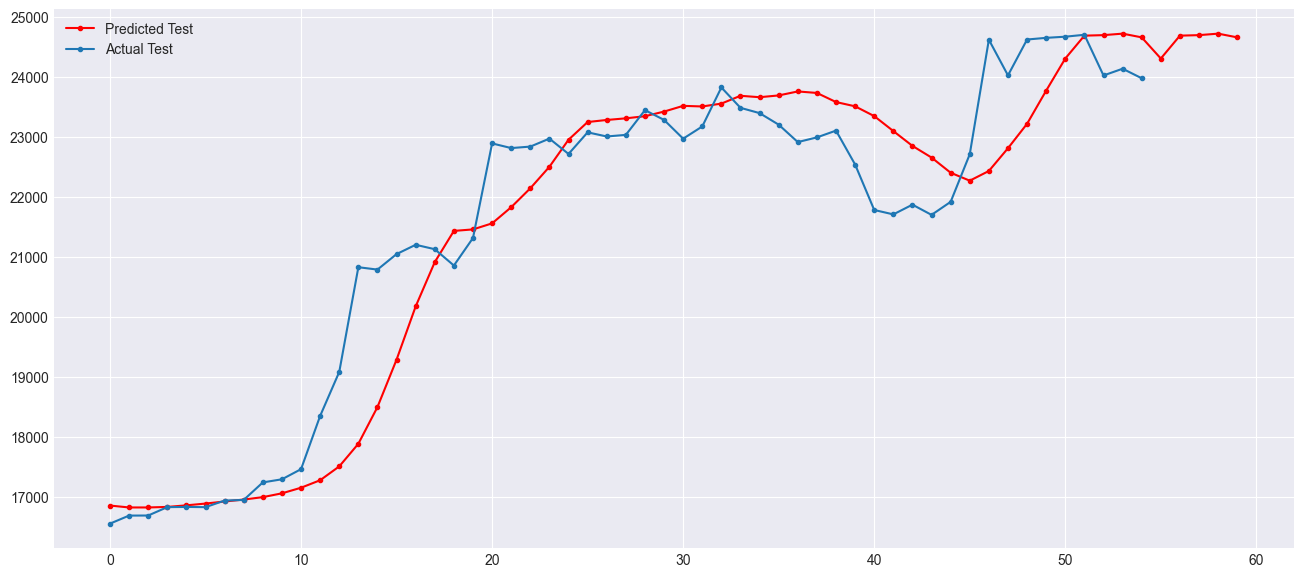

In [92]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()